<a href="https://colab.research.google.com/github/LikaOkudzhava/BrainyScan/blob/main/Alzheimer_model_RestNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os
import zipfile
from google.colab import drive
gdrive = '/content/drive'
drive.mount(gdrive, force_remount=False)
gdisk = os.path.join(gdrive, 'MyDrive')
filename = 'Copy of smallpreprocessed (1)'
archive_path = os.path.join(gdisk, filename)
with zipfile.ZipFile('/content/drive/MyDrive/smallpreprocessed.zip', 'r') as zip_ref:
 zip_ref.extractall(f'{filename}_extracted')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:

import os
import cv2

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime

# from imblearn.over_sampling import SMOTE

In [18]:
dataset_dir = '/content/smallpreprocessed/data/SmallPreprocessed'
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet.preprocess_input,
    rescale=1./255,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

Found 12000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


In [19]:
model = keras.models.Sequential()
model.add(
    tf.keras.applications.ResNet50(
        input_shape = (image_size[0], image_size[1], 3),
        include_top = False,
        pooling = 'avg',
        weights = 'imagenet'))

model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4, activation='softmax'))
model.layers[0].trainable = False

# Build the model with the correct input shape
model.build(input_shape=(None, image_size[0], image_size[1], 3))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,906,820 (114.09 MB)

 Trainable params: 6,308,868 (24.07 MB)

 Non-trainable params: 23,597,952 (90.02 MB)

In [20]:
checkpoint_cb = ModelCheckpoint(
    "model_ResNet50.keras",
    save_best_only = True)

early_stopping_cb = EarlyStopping(
    patience = 10,
    restore_best_weights = True
)

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [21]:
EPOCHS = 20

In [22]:
hist = model.fit(
    train_generator,
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks = [checkpoint_cb, early_stopping_cb]
)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 126ms/step - accuracy: 0.5026 - loss: 1.4424 - val_accuracy: 0.3635 - val_loss: 1.5867
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 45s 120ms/step - accuracy: 0.6258 - loss: 0.8668 - val_accuracy: 0.6005 - val_loss: 1.0553
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.6545 - loss: 0.8185 - val_accuracy: 0.6445 - val_loss: 0.8466
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/step - accuracy: 0.6850 - loss: 0.7557 - val_accuracy: 0.6810 - val_loss: 0.7492
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 115ms/step - accuracy: 0.7092 - loss: 0.7102 - val_accuracy: 0.7040 - val_loss: 0.7251
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.7285 - loss: 0.6464 - val_accuracy: 0.7375 - val_loss: 0.6814
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 106ms/step - accuracy: 0.7501 - loss: 0.6081 - val_accuracy: 0.7200 - val_loss: 0.7148
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.7632 - loss: 0

In [23]:
model.save('/content/smallpreprocessed/data/SmallPreprocessed/ResNet50.keras')
#model = keras.models.load_model('/content/smallpreprocessed/data/SmallPreprocessed/ResNet50.keras')
#model.export('../models/template_model')

In [10]:
score, acc= model.evaluate(test_generator)
print('Val Loss =', score)
print('Val Accuracy =', acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.8378 - loss: 0.4095
Val Loss = 0.4206569492816925
Val Accuracy = 0.8330000042915344


In [24]:
hist_=pd.DataFrame(hist.history)

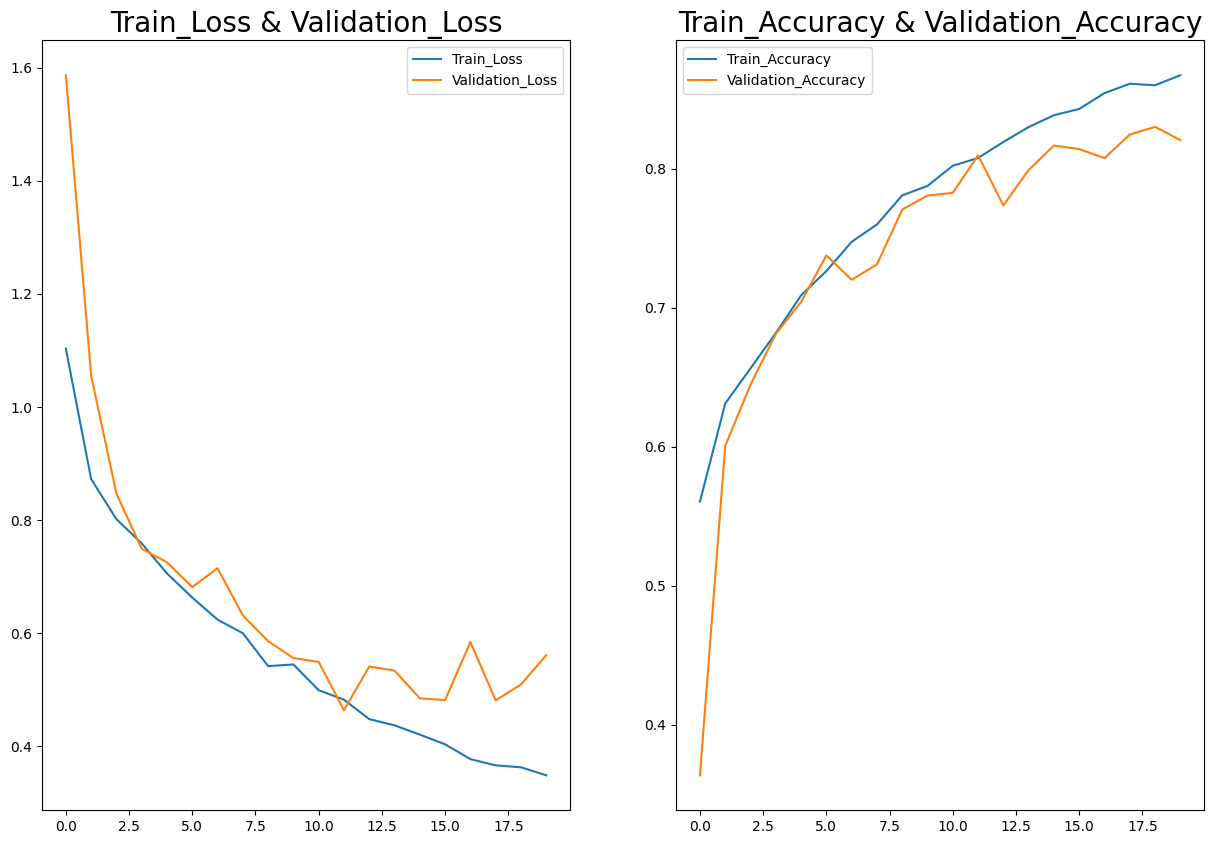

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [13]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step


In [ ]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
CM

In [ ]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_num)
print('Classification Report is : ', ClassificationReport)